# PyTorchとQiskitを用いた量子古典ハイブリッド・ニューラル・ネットワーク

機械学習 (Machine learning、ML) は、データから一般化された情報を数学的に抽出しようとする学際的分野を自分自身で確立しました。量子コンピューターを利用することで、機械学習を補完するため量子力学の原理を利用したり、あるいはその逆を行う興味深い研究分野が増加しています。 難しい計算を量子コンピューターに任せることで古典MLアルゴリズムを拡張するにせよ、古典MLアルゴリズムを用いて量子アルゴリズムを最適化するにせよ、どちらも量子機械学習(quantum machine learning、QML)の多種多様な傘下にあるのです。

本章では、古典的なニューラル・ネットワークを部分的に量子化して、量子古典ハイブリッド・ニューラル・ネットワークを作る方法を探求します。Qiskitと最新のオープン・ソース・ソフトウェア・パッケージ - [PyTorch](https://pytorch.org/) - を統合する簡単な例をコーディングします。これは、既存のMLツールとQiskitの統合が簡単であることを示すことと、ML学習者に量子コンピューティングで何が可能になるか探究してもらうことを目的としています。

## どのように機能するのか?
<img src="hybridnetwork.png" width="800"/>

**図.1** は、本章で構築するフレームワークを描いたものです。最終的には、手書きの数字を分類しようとする、量子古典ハイブリッド・ニューラル・ネットワークを構築します。 この図に示されているエッジはすべて下方を向いていますが、方向性は視覚的に示されていないことに注意してください。

### 導入
ここで語られる古典ニューラル・ネットワークの背景には、関連する知識や共通の用語の確立も含まれますが、俄然とてもハイレベルなものです。__もし古典ニューラル・ネットワークに深く踏み込みたい場合は、YouTuberによるよくできたビデオシリーズ__  [3Blue1Brown](https://youtu.be/aircAruvnKk) __をご覧ください__。または、もし既に古典ネットワークに詳しい場合は [次のセクションにスキップ](#quantumlayer) できます。

###### ニューロンと重み
ニューラル・ネットワークは、最終的には、ニューロンと呼ばれる小さなビルディング・ブロックを構成することで作られる精巧な機能です。***ニューロン*** は、通常シンプルで計算しやすい非線形の関数で、1つ以上の入力を1つの実数にマップします。ニューロンの一つの出力は、通常他のニューロンへの入力としてコピーされフィードされます。図示する場合、ニューロンをグラフ内のノードとして表し、あるニューロンの出力が他のニューロンへの入力としてどのように使用されるかを示すため、ノード間の有向エッジを描画します。また、グラフ内の各エッジは、しばしば[***重み***](https://en.wikipedia.org/wiki/Artificial_neural_network#Connections_and_weights)と呼ばれるスカラー値に関連付けられることに注意する必要があります。ここでの考え方は、ニューロンへの各入力はそれぞれ異なるスカラー値が乗じられた後、集められて1つの値に処理されるということです。ニューラル・ネットワークの学習の主たる目的は、特定の方法でネットワーク振る舞うよう重みを決めることです。

###### フィードフォワード・ニューラル・ネットワーク
また、私たちが関心のあるタイプのニューラル・ネットワークは、**[フィードフォワード・ニューラル・ネットワーク (Feed-Forward Neural Network, FFNN)](https://en.wikipedia.org/wiki/Feedforward_neural_network)** と呼ばれることにも注目する必要があります。これは、ニューラル・ネットワークにデータが流れるとき、データは一度訪れているニューロンに戻ることがないことを意味します。言い換えるならば、このニューラル・ネットワークを記述するグラフは、**[有向非巡回グラフ (Directed Acyclic Graph, DAG)](https://en.wikipedia.org/wiki/Directed_acyclic_graph)** だということです。さらに、ニューラル・ネットワークの同じ層にあるニューロンは、それらの間にエッジがないことも条件となります。

###### 層のIO構造
ニューラル・ネットワークへの入力は、古典的な(実数値の)ベクトルです。入力ベクトルの各成分は、ネットワークのグラフ構造に従って、異なる重みを乗じられ、ニューロンの層にフィードされます。 層内の各ニューロンが評価された後、結果は新しいベクトルに集められ、 i番目の成分はi番目のニューロンの出力を記録します。この新しいベクトルは、新しい層の入力として処理され、以下同様に処理されます。ネットワークの最初と最後以外の層は、***隠れ層*** という標準的用語を使って表現しましょう。


## 量子はどのように画像を入力するのか？ <a id='quantumlayer'> </a>

量子古典ニューラル・ネットワークを構築するには、パラメータ化された量子回路を使用してニューラル・ネットワークの隠れ層を実装する方法があります。 ここで「パラメータ化された量子回路」とは、各ゲートの回転角が古典入力ベクトルの成分によって指定される量子回路を意味します。ニューラル・ネットワークの前の層からの出力が集められ、パラメーター化された回路の入力として使用されます。これらの量子回路の測定統計は集められ、続くの層の入力として使用することができます。以下に簡単な例を示します：

<img src="neuralnetworkQC.png" width="800"/>

ここで、$\sigma$ は [非線形関数](https://en.wikipedia.org/wiki/Activation_function)、$h_i$ は各隠れ層におけるニューロン $i$ の値です。$R(h_i)$ は $h_i$ に等しい角の回転ゲートを表し、$y$はこのハイブリッド・ネットワークから生成される最終予測値になります。

### 誤差逆伝播法はどうか？
古典MLに詳しいならば、 *量子回路が含まれる場合、どのように勾配を計算するのか* という疑問がすぐ浮かぶでしょう。これには、**[最急降下法](https://en.wikipedia.org/wiki/Gradient_descent)** といった、強力な最適化手法を列挙する必要があるでしょう。少し技術的になりますが、手短に言えば、量子回路をブラック・ボックスとみなすとき、パラメーターに対するこのブラック・ボックスの勾配は次のように計算できます： 

<img src="quantumgradient.png" width="800"/>

ここで、$\theta$ は量子回路のパラメーターを、$s$ は巨視的シフトを表します。すると、勾配は回路を $\theta+s$ と $\theta - s$ で評価した時の差になります。このように、より大きな誤差伝播ルーチンの一部として、量子回路を体系的に区別することができます。量子回路パラメータの勾配を計算するこの閉形式ルールは、**[パラメーター・シフト・ルール](https://arxiv.org/pdf/1905.13311.pdf)** として知られています。

# いざ、コーディング ！


### インポート
最初に、QiskitやPyTorchを含め、必要で便利なパッケージをインポートします。

In [1]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, execute
from qiskit.circuit import Parameter
from qiskit import Aer
from matplotlib import pyplot as plt
%matplotlib inline

### テンソルをリストに
次に、Pythonでテンソルをリストに変換する追加の関数を作成します。これは、QiskitとPyTorchのオブジェクトを結びつけるために必要です。特に、Pytorchによって生成されたテンソルをリストに変換し、Qiskitの量子回路にフィードさせるために使用します。 

In [2]:
def to_numbers(tensor_list):
    num_list = []
    for tensor in tensor_list:
        num_list += [tensor.item()]
    return num_list

### Qiskitを用いた「量子クラス」の作成
Qiskitの量子関数をクラスに簡単に導入することができます。初めに、学習する量子パラメータの数と、量子回路で使用したいショットの数を指定します。 この例では、簡単にするため、1つの学習量子パラメーター $\theta$を持つ1量子ビットの回路を使用します。単純化するため回路をハードコードし、角度 $\theta$ の $RY-$ 回転を使用して、回路の出力を学習させます。回路は次のようになります：

<img src="1qubitcirc.png" width="400"/>

$z-$基底で出力を測定するため、$\sigma_z$ 期待値を得るPython関数を作成します。最後に、パラメーターをリストに変換し、Aerシミュレーター上で回路を実行する「bind」関数を作成します。これがハイブリッド・ニューラル・ネットワークにどのように結びつくか、後ほど詳しく見ます。

In [3]:
class QiskitCircuit():
    
    # Specify initial parameters and the quantum circuit
    
    def __init__(self,shots):
        self.theta = Parameter('Theta')
        self.shots = shots
        
        def create_circuit():
            qr = QuantumRegister(1,'q')
            cr = ClassicalRegister(1,'c')
            ckt = QuantumCircuit(qr,cr)
            ckt.h(qr[0])
            ckt.barrier()
            ckt.ry(self.theta,qr[0])
            ckt.barrier()
            ckt.measure(qr,cr)
            return ckt
        
        self.circuit = create_circuit()
        
    def N_qubit_expectation_Z(self, counts, shots, nr_qubits):
        expects = np.zeros(nr_qubits)
        for key in counts.keys():
            perc = counts[key]/shots
            check = np.array([(float(key[i])-1/2)*2*perc for i in range(nr_qubits)])
            expects += check   
        return expects    
    
    def bind(self, parameters):
        [self.theta] = to_numbers(parameters)
        self.circuit.data[2][0]._params = to_numbers(parameters)
    
    def run(self, i):
        self.bind(i)
        backend = Aer.get_backend('qasm_simulator')
        job_sim = execute(self.circuit,backend,shots=self.shots)
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts,self.shots,1)

### PyTorchを用いた「量子古典クラス」の作成
量子回路を定義できましたので、 PyTorchを使って誤差逆伝播法に必要な関数を作成できます。[順伝播と逆伝播](http://www.ai.mit.edu/courses/6.034b/backprops.pdf) には、Qiskitクラスの要素が含まれています。 逆伝播は、上記で導入した有限差分公式を使用して、分析勾配を直接計算します。

In [4]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(shots=100)
            
        exp_value = ctx.QiskitCirc.run(i[0])
        
        result = torch.tensor([exp_value]) # store the result as a torch tensor
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        s = np.pi/2
        
        forward_tensor, i = ctx.saved_tensors  
        
        # Obtain paramaters 
        input_numbers = to_numbers(i[0])
        
        gradient = []
        
        for k in range(len(input_numbers)):
            input_plus_s = input_numbers
            input_plus_s[k] = input_numbers[k] + s  # Shift up by s
            
            exp_value_plus = ctx.QiskitCirc.run(torch.tensor(input_plus_s))[0]
            result_plus_s = torch.tensor([exp_value_plus])
            
            input_minus_s = input_numbers
            input_minus_s[k] = input_numbers[k] - s # Shift down by s
            
            exp_value_minus = ctx.QiskitCirc.run(torch.tensor(input_minus_s))[0]
            result_minus_s = torch.tensor([exp_value_minus])

            gradient_result = (result_plus_s - result_minus_s)

            gradient.append(gradient_result)
            
        result = torch.tensor([gradient])
        
        return result.float() * grad_output.float()

これらをすべてをまとめて、[MNIST データ・セット](http://yann.lecun.com/exdb/mnist/) の2種類の数字（0または1）のイメージを分類するための、簡単なハイブリッド・ニューラル・ネットワークを作成します。まずMNISTをロードし、0と1を含む画像をフィルタリングします。これらは、分類するニューラル・ネットワークの入力として扱われます。

### データのロードと前処理

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # transform images to tensors/vectors
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

labels = mnist_trainset.targets # get the labels for the data
labels = labels.numpy()

idx1 = np.where(labels == 0) # filter on zeros
idx2 = np.where(labels == 1) # filter on ones

# Specify number of datapoints per class (i.e. there will be n pictures of 1 and n pictures of 0 in the training set)
n=100

# concatenate the data indices
idx = np.concatenate((idx1[0][0:n],idx2[0][0:n])) 

# create the filtered dataset for our training set
mnist_trainset.targets = labels[idx] 
mnist_trainset.data = mnist_trainset.data[idx]

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=1, shuffle=True)

データは、0と1の2つのクラスに属するイメージで構成されます。イメージの例は以下の通りです：

<img src="MNISTplot.png" width="100"/>

ここまでで、データをロードし、1つの学習パラメータを含む量子回路を作成するクラスをコーディングしました。この量子パラメータは、他の古典パラメータとともに古典ニューラル・ネットワークに入力され、ハイブリッド・ニューラル・ネットワークを形成します。また、逆伝播・順伝播関数を作ることにより、誤差逆伝播法を実現しニューラル・ネットワークを最適化することができました。最後に、PyTorchが提供する最適化技術を使って、パラメーターの学習を開始できるよう、ニューラル・ネットワーク・アーキテクチャーを指定する必要があります。


### ハイブリッド・ニューラル・ネットワークの作成
NEAT PyTorchパイプラインを使って、ニューラルネットワーク・アーキテクチャを構築できます。量子層（すなわち量子回路）を挿入する場合、ネットワークは次元に対して互換性が必要です。この例の量子回路はパラメータを1つ含んでいるので、ネットワークがニューロンをサイズ1まで縮小するようにしなければなりません。それぞれ320、50、1個のニューロンで構成される、3つの隠れ層からなるネットワークを作成します。最後のニューロンの値は、量子回路のパラメータ $\theta$ の値としてフィードされます。回路測定は、$\sigma_z$の測定によってもたらされる0または1の最終予測値として与えられます。 測定結果の-1は予測ラベル0を、1は予測ラベル1を意味します。  

In [6]:
qc = TorchCircuit.apply 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.h1 = nn.Linear(320, 50)
        self.h2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.h1(x))
        x = F.dropout(x, training=self.training)
        x = self.h2(x)
        x = qc(x)
        x = (x+1)/2  # Normalise the inputs to 1 or 0
        x = torch.cat((x, 1-x), -1)
        return x

### ネットワークの学習
ハイブリッド・ネットワークを学習させる全ての材料が揃いました！複数のエポックに渡り学習させるため、[PyTorchの最適化法](https://pytorch.org/docs/stable/optim.html)や[学習率](https://en.wikipedia.org/wiki/Learning_rate) 、 [損失関数/目的関数](https://en.wikipedia.org/wiki/Loss_function) などを指定することができます。この例では、[Adam最適化ツール](https://arxiv.org/abs/1412.6980) 、学習率0.001、[負の対数尤度損失関数](https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html) を使用します。

In [7]:
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

epochs = 30
loss_list = []
for epoch in range(epochs):
    total_loss = []
    target_list = []
    for batch_idx, (data, target) in enumerate(train_loader):
        target_list.append(target.item())
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print(loss_list[-1])

# Normalise the loss between 0 and 1
for i in range(len(loss_list)):
    loss_list[i] += 1

-0.6777499999999997


-0.7646999999999997


-0.7769999999999994


-0.7820000000000004


-0.7879999999999998


-0.7911999999999998


-0.8037499999999997


-0.8130500000000004


-0.7991499999999998


-0.8133500000000002


-0.8038999999999994


-0.8146499999999998


-0.8097000000000001


-0.8126500000000001


-0.8120499999999998


-0.8110999999999997


-0.8172499999999993


-0.8307500000000002


-0.82465


-0.8127000000000001


-0.8352000000000009


-0.8245500000000001


-0.82715


-0.8143500000000005


-0.8272999999999991


-0.8291999999999997


-0.8361500000000005


-0.8263500000000001


-0.8310499999999996


-0.8289999999999993


Text(0, 0.5, 'Loss')

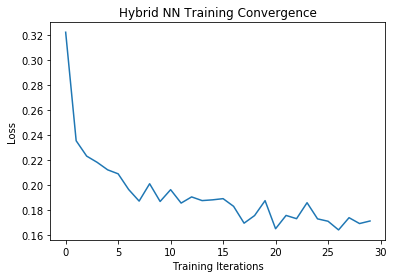

In [8]:
# Plot the loss per epoch
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

# 次は何？

ハイブリッド・ニューラルネットワークを作成することは確かに可能ですが、実際に何らかの恩恵があったでしょうか？事実、このネットワークの古典的な層は、量子層がなくとも完全に良く（実際には、より良く）学習されます。さらに、ここで学習された量子層は、**エンタングルメントを全く生成しない**ことに気が付いたかもしれません。つまり、この特定のアーキテクチャーを拡張する際は、古典的にシミュレーション可能であるということです。これは、ハイブリッド・ニューラル・ネットワークを使用して量子優位性を実現したい場合は、このコードを拡張し、より洗練された量子層を組み込むことから始める必要があることを意味します。 


この演習のポイントは、興味のある要素が実際にあるかを調べるため、MLと量子コンピューティングの技術の統合を考えることでした。PyTorchとQiskitのおかげで、これは少し楽になっています。 